# Linear scaling

This notebook applies a linear scaling approach to correct the bias of seasonal forecasts, in this case the ECMWF SEAS5 rainfall, temperature and evaporation ensembles. A bias monthly correction factor is calculated considering the ratio between the monthly average observed and the forecast (ensemble mean) values. The correction factor obtained is then applied as a multiplicative factor to correct raw daily forecast value. This approach is simple and still with similar results to more sophisticated ones such as the quantile or distribution mapping (Crochemore et al., 2016).

## 1. Import general libraries
First, we need to import the necessary libraries and sub-modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
from netCDF4 import Dataset # to extract data from NetCDF files (format of the downloaded ECMWF files)
import numba # a just-in-time compiler to speed up the code

from Submodules.Climatology_data import Climatology_data
from Submodules.TUWmodel import TUWmodel

months = dates.MonthLocator()  # every month
months_fmt = dates.DateFormatter('%M')

## 2. Initial options
Second, we define the seasonal forecast provider, the initial date of the forecast and the area of the catchment.

In [2]:
provider = 'ECMWF' # seasonal forecast provider
folder_path = provider+' files' # folder containing the downloaded forecast files
year     = 2014   # year
month    = 11     # month
day      = 1      # day
catchment_area = 28.8 # km2

## 3. Load data and define bias correction
### 3.1 Forecast data
The downloaded forecast files are in NetCDF (Network Common Data Form) format. This file format supports the creation, access, and sharing of array-oriented scientific data.
#### 3.1.1 Load NetCDF data

In [3]:
data_fore = Dataset(folder_path+"//"+str(year)+str(month).zfill(2)+
                    str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain.nc", "r")
dates_fore = pd.to_datetime(data_fore['time'][:]-24, 
                            unit='h', # hourly
                            origin = pd.Timestamp('01-01-1900'))
# the next day at 00:00 we need to substract one day (-24h) 
# to reflect that the first data member corresponds to the first 
# day and not to the next day at 00:00

# Number of members of the forecast ensemble 
num_mem = data_fore.dimensions['number'].size

#### 3.1.2 Extract temperature data (temperature at 2m over the surface: 't2m')
Original data is in degK

In [4]:
Temp_fore=data_fore.variables['t2m'][:]
# Spatially averaged data and coverted into degC
Temp_fore_ens = Temp_fore.mean(3).mean(2)-273.15

#### 3.1.3 Extract evaporation data (evaporation: 'e')
Original data is in daily cumulative meters. We need a function to transform cumulative data into instantaneous.

In [5]:
# Function to transform cumulative data into instantaneous data
@numba.jit(nopython=True) # to speed-up the function
def cum2inst(cum_data):
    inst_data = np.zeros(cum_data.shape)
    for i in np.arange(len(cum_data[0,:])):
        for j in np.arange(len(cum_data[:,0])-1):
            inst_data[j+1,i] = np.maximum(cum_data[j+1,i]-cum_data[j,i],0)
    return inst_data

In [6]:
Evap_fore=data_fore.variables['e'][:]
# Spatially averaged data and coverted into mm
Evap_fore_cum = -Evap_fore.mean(3).mean(2)*1000
# Cumulative to instantaneous data
from timeit import default_timer as timer
Evap_fore_ens = cum2inst(Evap_fore_cum)

#### 3.1.4 Extract rainfall data (total precipitation: 'tp')
Original data is in daily cumulative meters

In [7]:
Rain_fore=data_fore.variables['tp'][:]
# Spatially averaged data and coverted into mm
Rain_fore_cum = Rain_fore.mean(3).mean(2)*1000
# Cumulative to instantaneous data
Rain_fore_ens = cum2inst(Rain_fore_cum)

#### 3.1.5 Number of months covered by the forecast

In [8]:
if month>dates_fore[-1].month:
    num_months = dates_fore[-1].month - month + 1 + 12
else:
    num_months = dates_fore[-1].month - month + 1

#### 3.1.6 Plot the extracted data (in this case the rainfall forecast ensemble)

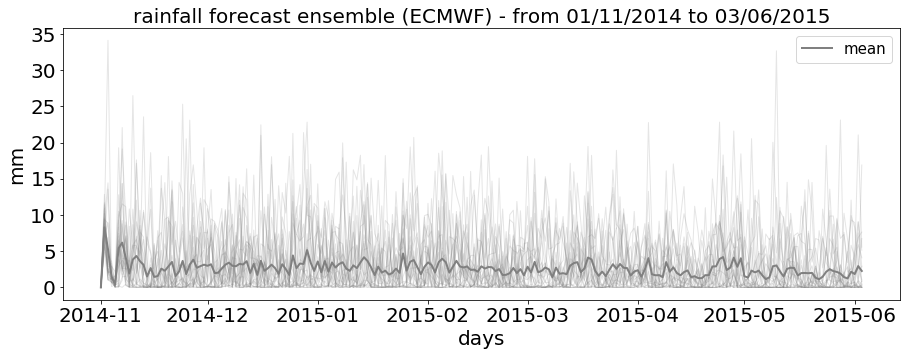

In [9]:
fig1,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(dates_fore,
         Rain_fore_ens,
         'grey',
         alpha=0.2,
         linewidth=1)
ax1.plot(dates_fore,
         np.mean(Rain_fore_ens,axis=1),
         'grey',
         alpha=1,
         linewidth=2, 
         label = 'mean')
ax1.set_xlabel('days', 
               fontsize = 20)
ax1.set_ylabel('mm', 
               fontsize = 20)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
ax1.set_title('rainfall forecast ensemble (ECMWF) - from '+dates_fore[0].strftime("%d/%m/%Y")+
              ' to '+dates_fore[-1].strftime("%d/%m/%Y"), 
              fontsize = 20)
ax1.legend(fontsize = 15)
plt.show()

### 3.2 Observed weather data
In order to bias correct the forecast, we need to estimate the bias, i.e. difference between the forecast and the observations. For this purpose, we load available observed weather data from our catchment of study.

In [10]:
# File path
path_obs_data = 'Observed data//ClimdataWim.csv'
# Loading the observed weather data file using Numpy and extracting the date array using Pandas
dates_obs_data = pd.to_datetime(np.genfromtxt(path_obs_data,
                                              delimiter = ',',
                                              skip_header=1,
                                              usecols=0,
                                              dtype='str'),
                                format = '%d/%m/%Y')
# Loading the observed weather data file using Numpy
obs_data = np.genfromtxt(path_obs_data, 
                        delimiter = ',',
                        skip_header=1)
Evap_obs = obs_data[0:,1]
Rain_obs = obs_data[0:,2]
Temp_obs = obs_data[0:,3]

Plotting the available observed data (rainfall)

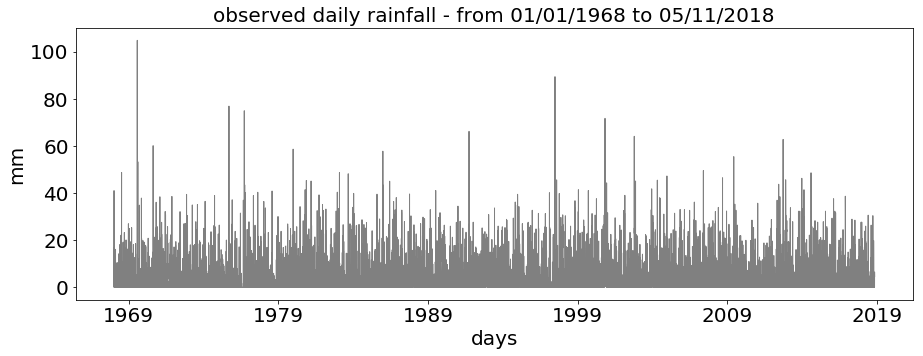

In [11]:
fig1,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(dates_obs_data,
         Rain_obs,
         'grey',
         alpha=1,
         linewidth=1)
ax1.set_xlabel('days', 
               fontsize = 20)
ax1.set_ylabel('mm', 
               fontsize = 20)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
ax1.set_title('observed daily rainfall - from '+dates_obs_data[0].strftime("%d/%m/%Y")+
              ' to '+dates_obs_data[-1].strftime("%d/%m/%Y"),
              fontsize = 20)
plt.show()

### 3.3 Climatology
Climatology is defined as the ensemble of historical data corresponging to the period of study. Each member of the ensemble corresponds to a year.

In [12]:
clim_ini_year = 1981
clim_end_year = year - 1

# Transforming the dates of the period of study (seasonal forecast) into year days (from 1 to 366)
ydays = np.zeros(len(dates_fore))
for i in range(len(dates_fore)):
    ydays[i] = int(dates_fore[i].timetuple().tm_yday)

Rain_clim = np.zeros((len(ydays),len(np.arange(clim_ini_year,year))))

count = 0
for y in np.arange(clim_ini_year,year):
    for i in range(len(ydays)):
        ID_clim = np.where((dates_obs_data.year==y) & (dates_obs_data.dayofyear==int(ydays[i])))[0]
        Rain_clim[i,count] = Rain_obs[ID_clim]
    count += 1
Rain_clim[0,:] = 0

Plotting the climatology

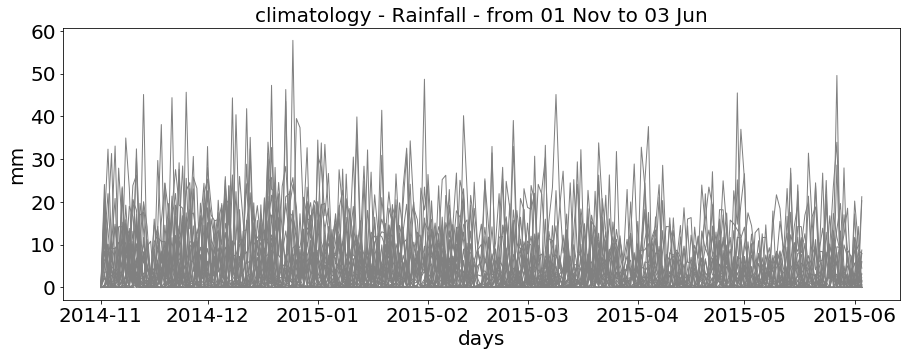

In [13]:
fig1,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(dates_fore,
         Rain_clim,
         'grey',
         alpha=1,
         linewidth=1)
ax1.set_xlabel('days', 
               fontsize = 20)
ax1.set_ylabel('mm', 
               fontsize = 20)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
ax1.set_title('climatology - Rainfall - from '+dates_fore[0].strftime("%d %b")+
              ' to '+dates_fore[-1].strftime("%d %b"),
              fontsize = 20)
plt.show()

### 3.4 Load control data (ECMWF seasonal hindcasts) and forecast bias correction

In [14]:
Temp_fore_corr= np.zeros(np.shape(Temp_fore_ens))
Evap_fore_corr= np.zeros(np.shape(Evap_fore_ens))
Rain_fore_corr= np.zeros(np.shape(Rain_fore_ens))

for i in np.arange(0,num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    Temp_ctrl_all = []
    Evap_ctrl_all  = []
    Rain_ctrl_all = []

    # Mean observed weather data for a given month in all the climatology years
    ID_obs = np.where((dates_obs_data.year>=clim_ini_year) & (dates_obs_data.year<year) & (dates_obs_data.month==m))[0]
    Temp_obs_mean = np.mean(Temp_obs[ID_obs])
    Evap_obs_mean = np.mean(Evap_obs[ID_obs])
    Rain_obs_all  = Rain_obs[ID_obs]
    Rain_obs_all[0] = 0
    Rain_obs_mean = np.mean(Rain_obs_all)
    
    
    # Control data for a given month in all the climatology years
    for y in np.arange(clim_ini_year,year):

        #Control/reference data
        ctrl_data = Dataset(folder_path+"//"+str(y)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain.nc", "r")

        dates_ctrl_data = pd.to_datetime(ctrl_data['time'][:]-24, unit='h',origin = pd.Timestamp('1900-01-01'))
        # the data is given every 24 h, so the it always starts the next day at 00:00 we need to substract 
        # one day (-24h) to reflect that the first data member corresponds to the first day and not to the next day at 00:00

        ID_ctrl = np.where((dates_ctrl_data.year>=clim_ini_year) & (dates_ctrl_data.month==m))[0]

        # Temperature
        Temp_ctrl=ctrl_data.variables['t2m'][:] # in degK
        Temp_ctrl_ens = Temp_ctrl.mean(3).mean(2).mean(1)-273.15 # in degC
        Temp_ctrl_all = np.append(Temp_ctrl_all,
                                  np.reshape(Temp_ctrl_ens[ID_ctrl],
                                             [np.size(Temp_ctrl_ens[ID_ctrl]),1]))
        
        # Evap
        Evap_ctrl=ctrl_data.variables['e'][:]*1000  # in mm 
        Evap_ctrl_cum = -Evap_ctrl.mean(3).mean(2).mean(1)
        Evap_ctrl_ens = np.zeros(np.shape(Evap_ctrl_cum))
        for j in np.arange(len(Evap_ctrl_cum[:])-1):
            Evap_ctrl_ens[j+1] = np.maximum(Evap_ctrl_cum[j+1]-Evap_ctrl_cum[j],0)
        Evap_ctrl_all = np.append(Evap_ctrl_all,
                                 np.reshape(Evap_ctrl_ens[ID_ctrl],
                                            [np.size(Evap_ctrl_ens[ID_ctrl]),1]))
        
        # Rainfall
        Rain_ctrl=ctrl_data.variables['tp'][:]*1000 # in mm 
        Rain_ctrl_cum = Rain_ctrl.mean(3).mean(2).mean(1)
        Rain_ctrl_ens = np.zeros(np.shape(Rain_ctrl_cum))
        for j in np.arange(len(Rain_ctrl_cum[:])-1):
            Rain_ctrl_ens[j+1] = np.maximum(Rain_ctrl_cum[j+1]-Rain_ctrl_cum[j],0)
        Rain_ctrl_all = np.append(Rain_ctrl_all,
                                  np.reshape(Rain_ctrl_ens[ID_ctrl],
                                             [np.size(Rain_ctrl_ens[ID_ctrl]),1]))
    
    # Mean control data
    Temp_ctrl_mean = np.mean(Temp_ctrl_all)
    Evap_ctrl_mean = np.mean(Evap_ctrl_all)
    Rain_ctrl_mean = np.mean(Rain_ctrl_all)
    
    # Bias correction factor for a given month
    Temp_bias_corr_factor = Temp_obs_mean/Temp_ctrl_mean
    Evap_bias_corr_factor = Evap_obs_mean/Evap_ctrl_mean
    Rain_bias_corr_factor = Rain_obs_mean/Rain_ctrl_mean
    
    # Define the forecast data each month
    ID_scen = np.where((dates_fore.year>=clim_ini_year) & (dates_fore.month==m))[0]
    Temp_scen = Temp_fore_ens[ID_scen]
    Evap_scen = Evap_fore_ens[ID_scen]
    Rain_scen = Rain_fore_ens[ID_scen]

    Temp_bias_corr = Temp_scen*Temp_bias_corr_factor
    Temp_fore_corr[ID_scen] = Temp_bias_corr

    Evap_bias_corr = Evap_scen*Evap_bias_corr_factor
    Evap_fore_corr[ID_scen] = Evap_bias_corr

    Rain_scen_corr = Rain_scen*Rain_bias_corr_factor
    Rain_fore_corr[ID_scen] = Rain_scen_corr

## 4. Plot results
### 4.1 Temperature

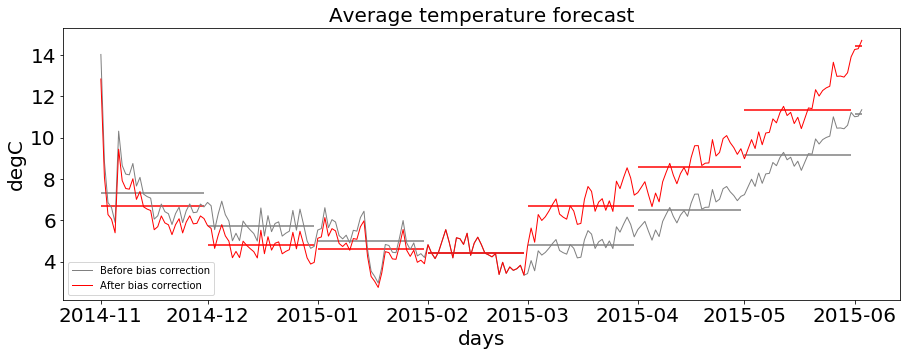

In [15]:
fig,ax0 = plt.subplots(figsize=(15, 5))
#ax0.plot(dates_fore,Temp_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax0.plot(dates_fore,Temp_fore_corr,'red',alpha=0.1,linewidth=1)
#ax0.plot(dates_fore,Temp_ctrl_ens,'blue',alpha=1,linewidth=2)
ax0.plot(dates_fore,np.mean(Temp_fore_ens,axis=1),'grey',alpha=1,linewidth=1,label='Before bias correction')
ax0.plot(dates_fore,np.mean(Temp_fore_corr,axis=1),'red',alpha=1,linewidth=1,label='After bias correction')
ax0.set_xlabel('days', fontsize = 20)
ax0.set_ylabel('degC', fontsize = 20)
for label in (ax0.get_xticklabels() + ax0.get_yticklabels()):
    label.set_fontsize(20)
Temp_fore_month_mean = np.zeros(num_months)
Temp_fore_corr_month_mean = np.zeros(num_months)
for i in range(num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    ID_month = np.where((dates_fore.month==m))[0]
    Temp_fore_month_mean [i] = np.mean(Temp_fore_ens[ID_month])
    Temp_fore_corr_month_mean [i] = np.mean(Temp_fore_corr[ID_month])
    ax0.hlines(Temp_fore_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='grey')
    ax0.hlines(Temp_fore_corr_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='red')
ax0.set_title('Average temperature forecast', fontsize = 20)
ax0.legend()
plt.show()

### 4.2 Evaporation

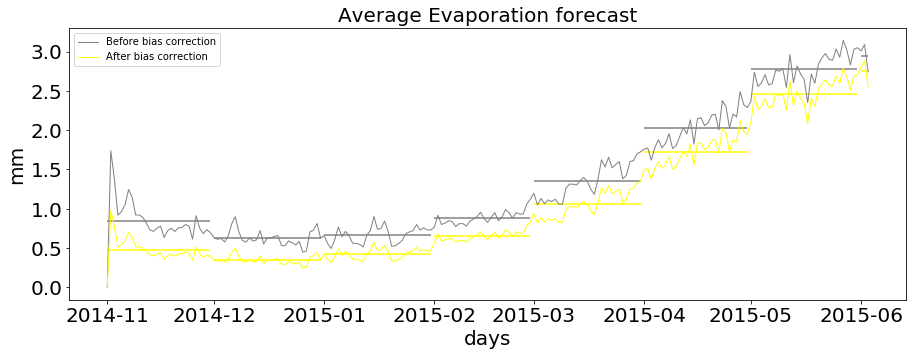

In [16]:
fig,ax1 = plt.subplots(figsize=(15, 5))
#ax1.plot(dates_fore,Evap_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax1.plot(dates_fore,Evap_fore_corr,'yellow',alpha=0.1,linewidth=1)
ax1.plot(dates_fore,np.mean(Evap_fore_ens,axis=1),'grey',alpha=1,linewidth=1,label='Before bias correction')
ax1.plot(dates_fore,np.mean(Evap_fore_corr,axis=1),'yellow',alpha=1,linewidth=1,label='After bias correction')
ax1.set_xlabel('days', fontsize = 20)
ax1.set_ylabel('mm', fontsize = 20)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
Evap_fore_month_mean = np.zeros(num_months)
Evap_fore_corr_month_mean = np.zeros(num_months)
for i in range(num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    ID_month = np.where((dates_fore.month==m))[0]
    Evap_fore_month_mean [i] = np.mean(Evap_fore_ens[ID_month])
    Evap_fore_corr_month_mean [i] = np.mean(Evap_fore_corr[ID_month])
    ax1.hlines(Evap_fore_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='grey')
    ax1.hlines(Evap_fore_corr_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='yellow',alpha=1)
ax1.set_title('Average Evaporation forecast', fontsize = 20)
ax1.legend()
plt.show()

### 4.3 Rainfall

<function matplotlib.pyplot.show(*args, **kw)>

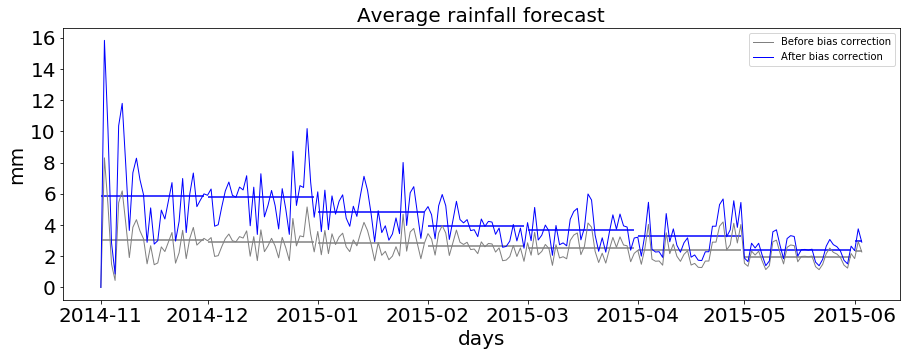

In [17]:
fig,ax2 = plt.subplots(figsize=(15, 5))
#ax2.plot(dates_fore,Rain_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax2.plot(dates_fore,Rain_fore_corr,'blue',alpha=0.1,linewidth=1)
#ax2.axhline(np.mean(np.mean(Rain_fore_ens[0:31,:])),color='grey')
ax2.plot(dates_fore,np.mean(Rain_fore_ens,axis=1),'grey',alpha=1,linewidth=1,label='Before bias correction')
#ax2.axhline(np.mean(np.mean(Rain_fore_corr[0:31,:])),color='blue')
ax2.plot(dates_fore,np.mean(Rain_fore_corr,axis=1),'blue',alpha=1,linewidth=1,label = 'After bias correction')
ax2.set_xlabel('days', fontsize = 20)
ax2.set_ylabel('mm', fontsize = 20)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
Rain_fore_month_mean = np.zeros(num_months)
Rain_fore_corr_month_mean = np.zeros(num_months)
for i in range(num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    ID_month = np.where((dates_fore.month==m))[0]
    Rain_fore_month_mean [i] = np.mean(Rain_fore_ens[ID_month])
    Rain_fore_corr_month_mean [i] = np.mean(Rain_fore_corr[ID_month])
    ax2.hlines(Rain_fore_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='grey')
    ax2.hlines(Rain_fore_corr_month_mean [i],xmin=dates_fore[ID_month[0]],xmax=dates_fore[ID_month[-1]],color='blue',alpha=1)
ax2.set_title('Average rainfall forecast', fontsize = 20)
#ax2.set_xlim([dates_fore[0],dates_fore[31]])
ax2.legend()
plt.show

## 5. Save bias corrected data to a file (.npy)

In [18]:
data_fore_bc = np.zeros([np.shape(Temp_fore_corr)[0],np.shape(Temp_fore_corr)[1],4])*np.nan
data_fore_bc[:,0,0] = data_fore['time'][:]-24
data_fore_bc[:,:,1] = Temp_fore_corr
data_fore_bc[:,:,2] = Evap_fore_corr
data_fore_bc[:,:,3] = Rain_fore_corr
#os.mkdir(provider+'//Bias corrected - LS')
#np.save(provider+"//Bias corrected - LS//"+str(year)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain",data_fore_bc)

## References

Crochemore, L., Ramos, M.-H., and Pappenberger, F.: Bias correcting precipitation forecasts to improve the skill of seasonal streamflow forecasts, Hydrol. Earth Syst. Sci., 20, 3601â€“3618, https://doi.org/10.5194/hess-20-3601-2016, 2016.